# Image Captioning

We will be implementing and analyzing diﬀerent components of some image captioning architectures. Check the src/layers.py file to follow along the write up.


## 0 - Setup 

To get correct setup to run the code, you will need to do the following:

(1) Create an anaconda environment that has Python 3.6 or Python 3.7

(2) We install the following dependencies:

 • PyTorch 1.0
 
 • NumPy 1.16.2
 
 • h5py 2.9.0
 
 • Matplotlib 3.0.3
 
 • SciPy 1.2.1
 
 • scikit-image 0.14.2

(3) Download the MS COCO captions and data splits from here: http://cs.stanford.edu/people/karpathy/deepimagesent/caption_datasets.zip

(4) We will not be using the entire MS COCO dataset. Instead, we will just download the validation set and work with subsets of the validation data as our train, validation, and test sets. Download the validation images from here: http://images.cocodataset.org/zips/ val2014.zip.

(5) Then uncompress both compressed caption JSON ﬁle and the compressed validation images. This will create 2 directories, caption dataset and val2014. Make sure you put these 2 directories within another directory.

(6) Run the preprocessing code with python preprocess data.py. You can run the command with the -h option to view the command line arguments. For the assignment, you should leave any arguments with their default value, if they have them; otherwise, you need to provide them. You can try other preprocessing conﬁgurations if you’re doing extra exploration, which is highly encouraged.

As an example, I ran the command as follows:

    python preprocess_data.py --json_split_path 'caption_datasets/dataset_coco.json' --image_dir ./ --data_dir preprocessed_data/

After running the command, the following output was produced

    INFO:root:Reading %s images and captions, storing to file...

    INFO:root:Reading %s images and captions, storing to file...

    INFO:root:Reading %s images and captions, storing to file...

    INFO:root:Saved input files with data_name: coco_2_cap_per_img_2_min_word_freq

Now that you have everything downloaded and uncompressed, take a look at some of the images and their captions to get a better understanding of the dataset.

## 1 - Vanilla RNN

Here we implement the forward pass of a vanilla RNN cell. We assume that data is stored in batches with a batch size of N. We ﬁrst implement a single step of the RNN cell to get a feel for the basic operations. Then we implement the full, multi-step RNN which is used in the rest of the assignment. The non-batch equation of the RNN is given by
ht = tanh(Wxxt−1 + Whht−1 + b), where xt ∈ RD, ht ∈ RH. The learnable parameters of the LSTM are an input-to-hidden matrix Wx ∈RH×D, a hidden-to-hidden matrix Wh ∈RH×H and a bias vector b ∈RH.

### 1.1 - Single Step

We've first implemented the init and forward methods of RNNDecoderSingle in src/layers.py. After finishing implementing a single step of a RNN, I run the test_rnn_single function in test layers.py to check the implementation. You should get an error of around $10^{-8}$ to $10^{-7}$.

In [3]:
!python -m unittest test_layers.TestRNN.test_rnn_single

Single step vanilla RNN error:  4.8648348564609165e-08
.
----------------------------------------------------------------------
Ran 1 test in 0.050s

OK


### 1.2 - Multi-step

Now we implement the init and forward methods of RNNDecoder in src/layers.py. This is a straightforward extension of the previous exercise. After, we implement the RNN for the entire input sequence and run the test rnn_multi_function in test layers.py to check the implementation. You should get an error of around $10^{-8}$ to $10^{-7}$.

In [1]:
!python -m unittest test_layers.TestRNN.test_rnn_multi

Multi-step vanilla RNN error:  8.723992968338852e-07
.
----------------------------------------------------------------------
Ran 1 test in 0.076s

OK


## 2 - LSTM

Here, we implement the forward pass of a LSTM cell for image captioning. Just as in the previous section, we ﬁrst implement a single step of the LSTM cell and then we implement the full, multi-step LSTM.

At each timestep we receive an input xt ∈ RD and the previous hidden state ht−1 ∈ RH. In contrast to the RNN, the LSTM also computes a cell state, so we also receive the previous cell state ct−1 ∈RH. The learnable parameters of the LSTM are an input-to-hidden matrix Wx ∈R4H×D, a hidden-to-hidden matrix Wh ∈R4H×H and a bias vector b ∈R4H. At each timestep, we ﬁrst compute an activation vector a(t) ∈R4H, which is given by a(t) = Wxxt + Whht−1 + b. 

We split this into four H-dimensional vectors, a(t) i ,a(t) f ,a(t) o ,a(t) g ∈ RH, where a(t) i consists of the ﬁrst H elements of a(t), and so on. Next, we compute the input gate g ∈RH, forget gate f ∈RH, output gate o ∈RH and block input g ∈RH as
it = σ(a(t) i ), ft = σ(a(t) f ), ot = σ(a(t) o ), gt = tanh(a(t) g ),
where σ is the sigmoid function and tanh is the hyperbolic tangent, both applied elementwise. Finally, we compute the next cell state ct and next hidden state ht as ct = ft ct−1 + it gt ht = ot tanh(ct) where  is the elementwise product. As before, we assume the data is stored in batches and we will work with transposed versions of the parameters. This allows us to eﬃciently compute activations A(t) ∈RN×4H as A(t) = XtWx + Ht−1Wh.

### 2.1 - Single Step

Now we implement a single step of a LSTM. Just like with the RNN, we implement the init and forward methods of LSTMDecoderSingle in src/layers.py. Once we have an implementation, run the test_lstm_single function in test layers.py to check the implementation. You should get an error of around $10^{-8}$ to $10^{-7}$.

In [5]:
!python -m unittest test_layers.TestLSTM.test_lstm_single

Single step LSTM next_h error:  7.284073647968282e-08
Single step LSTM next_c error:  1.0217306557660566e-07
.
----------------------------------------------------------------------
Ran 1 test in 0.004s

OK


### 2.2 - Multi-step

Now we implement the LSTM for the entire input sequence. We implement the init and forward methods of LSTMDecoder in src/layers.py. Run the test lstm_multi_function in test layers.py to check your implementation. Again, you should get an error of around $10^{-8}$ to $10^{-7}$.

In [2]:
!python -m unittest test_layers.TestLSTM.test_lstm_multi

Multi-step LSTM h error:  5.920183651186923e-07
.
----------------------------------------------------------------------
Ran 1 test in 0.040s

OK


## 3 - Output layer

We implement a linear output layer in both your RNN and LSTM decoders. This layer should produce an N ×V matrix, where V is the vocabulary size. This layer is integrated into our decoders, we make sure to return the result of this layer, rather than the hidden states. We do not add a softmax function as it is handled in the rest of the code.

    This is for the training. After implementing these, the test cases will fail due to size mismatch. 

## 4 - Attention Mechanism

Now we implement an attention mechanism and integrate it into the RNN and LSTM decoders. Speciﬁcally, you we implement the global, general attention (A.K.A. multiplicative attention) by Luong et al. (2015) (https://aclweb.org/anthology/D15-1166). In particular, we refer to Equations 5, 7, and 8. Once ﬁnished, we test your implementation with test layers.py. If our code is correct, doing so will give you an error of around $10^{-8}$ to $10^{-7}$.

In [1]:
!python -m unittest test_layers.TestAttention.test_attention

Attention context vector error:  4.230363928655063e-07
Attention scores error:  2.3640473474131808e-08
.
----------------------------------------------------------------------
Ran 1 test in 0.004s

OK


So in all, here are all the results of the tests:

In [4]:
!python -m unittest test_layers.py

Attention context vector error:  4.230363928655063e-07
Attention scores error:  2.3640473474131808e-08
.Multi-step LSTM h error:  5.920183651186923e-07
.Single step LSTM next_h error:  7.284073647968282e-08
Single step LSTM next_c error:  1.0217306557660566e-07
.Multi-step vanilla RNN error:  8.723992968338852e-07
.Single step vanilla RNN error:  4.8648348564609165e-08
.
----------------------------------------------------------------------
Ran 5 tests in 0.012s

OK


## 5 - Image Captioning

We try both of our implementations (RNN and LSTM, both with and without attention) on the MS COCO data. To do so, I run train.py to train the model. The implementation of the RNN decoder will be loaded by default. To train the LSTM implementation, make sure you add the argument --decoder cell type lstm. If possible, training for more epochs should help improve your model. We make sure to uncomment the reset parameters line in each of your decoder cells. When you are satisfied with your model, run test.py to see the results.

Unfortunately, my computer does not have a GPU and is not powerful enough to train anything so I trained each model for 3 epochs Google Cloud Platform. Below is the result of training for 3 epochs.

In [6]:
from IPython.core.display import Image, display

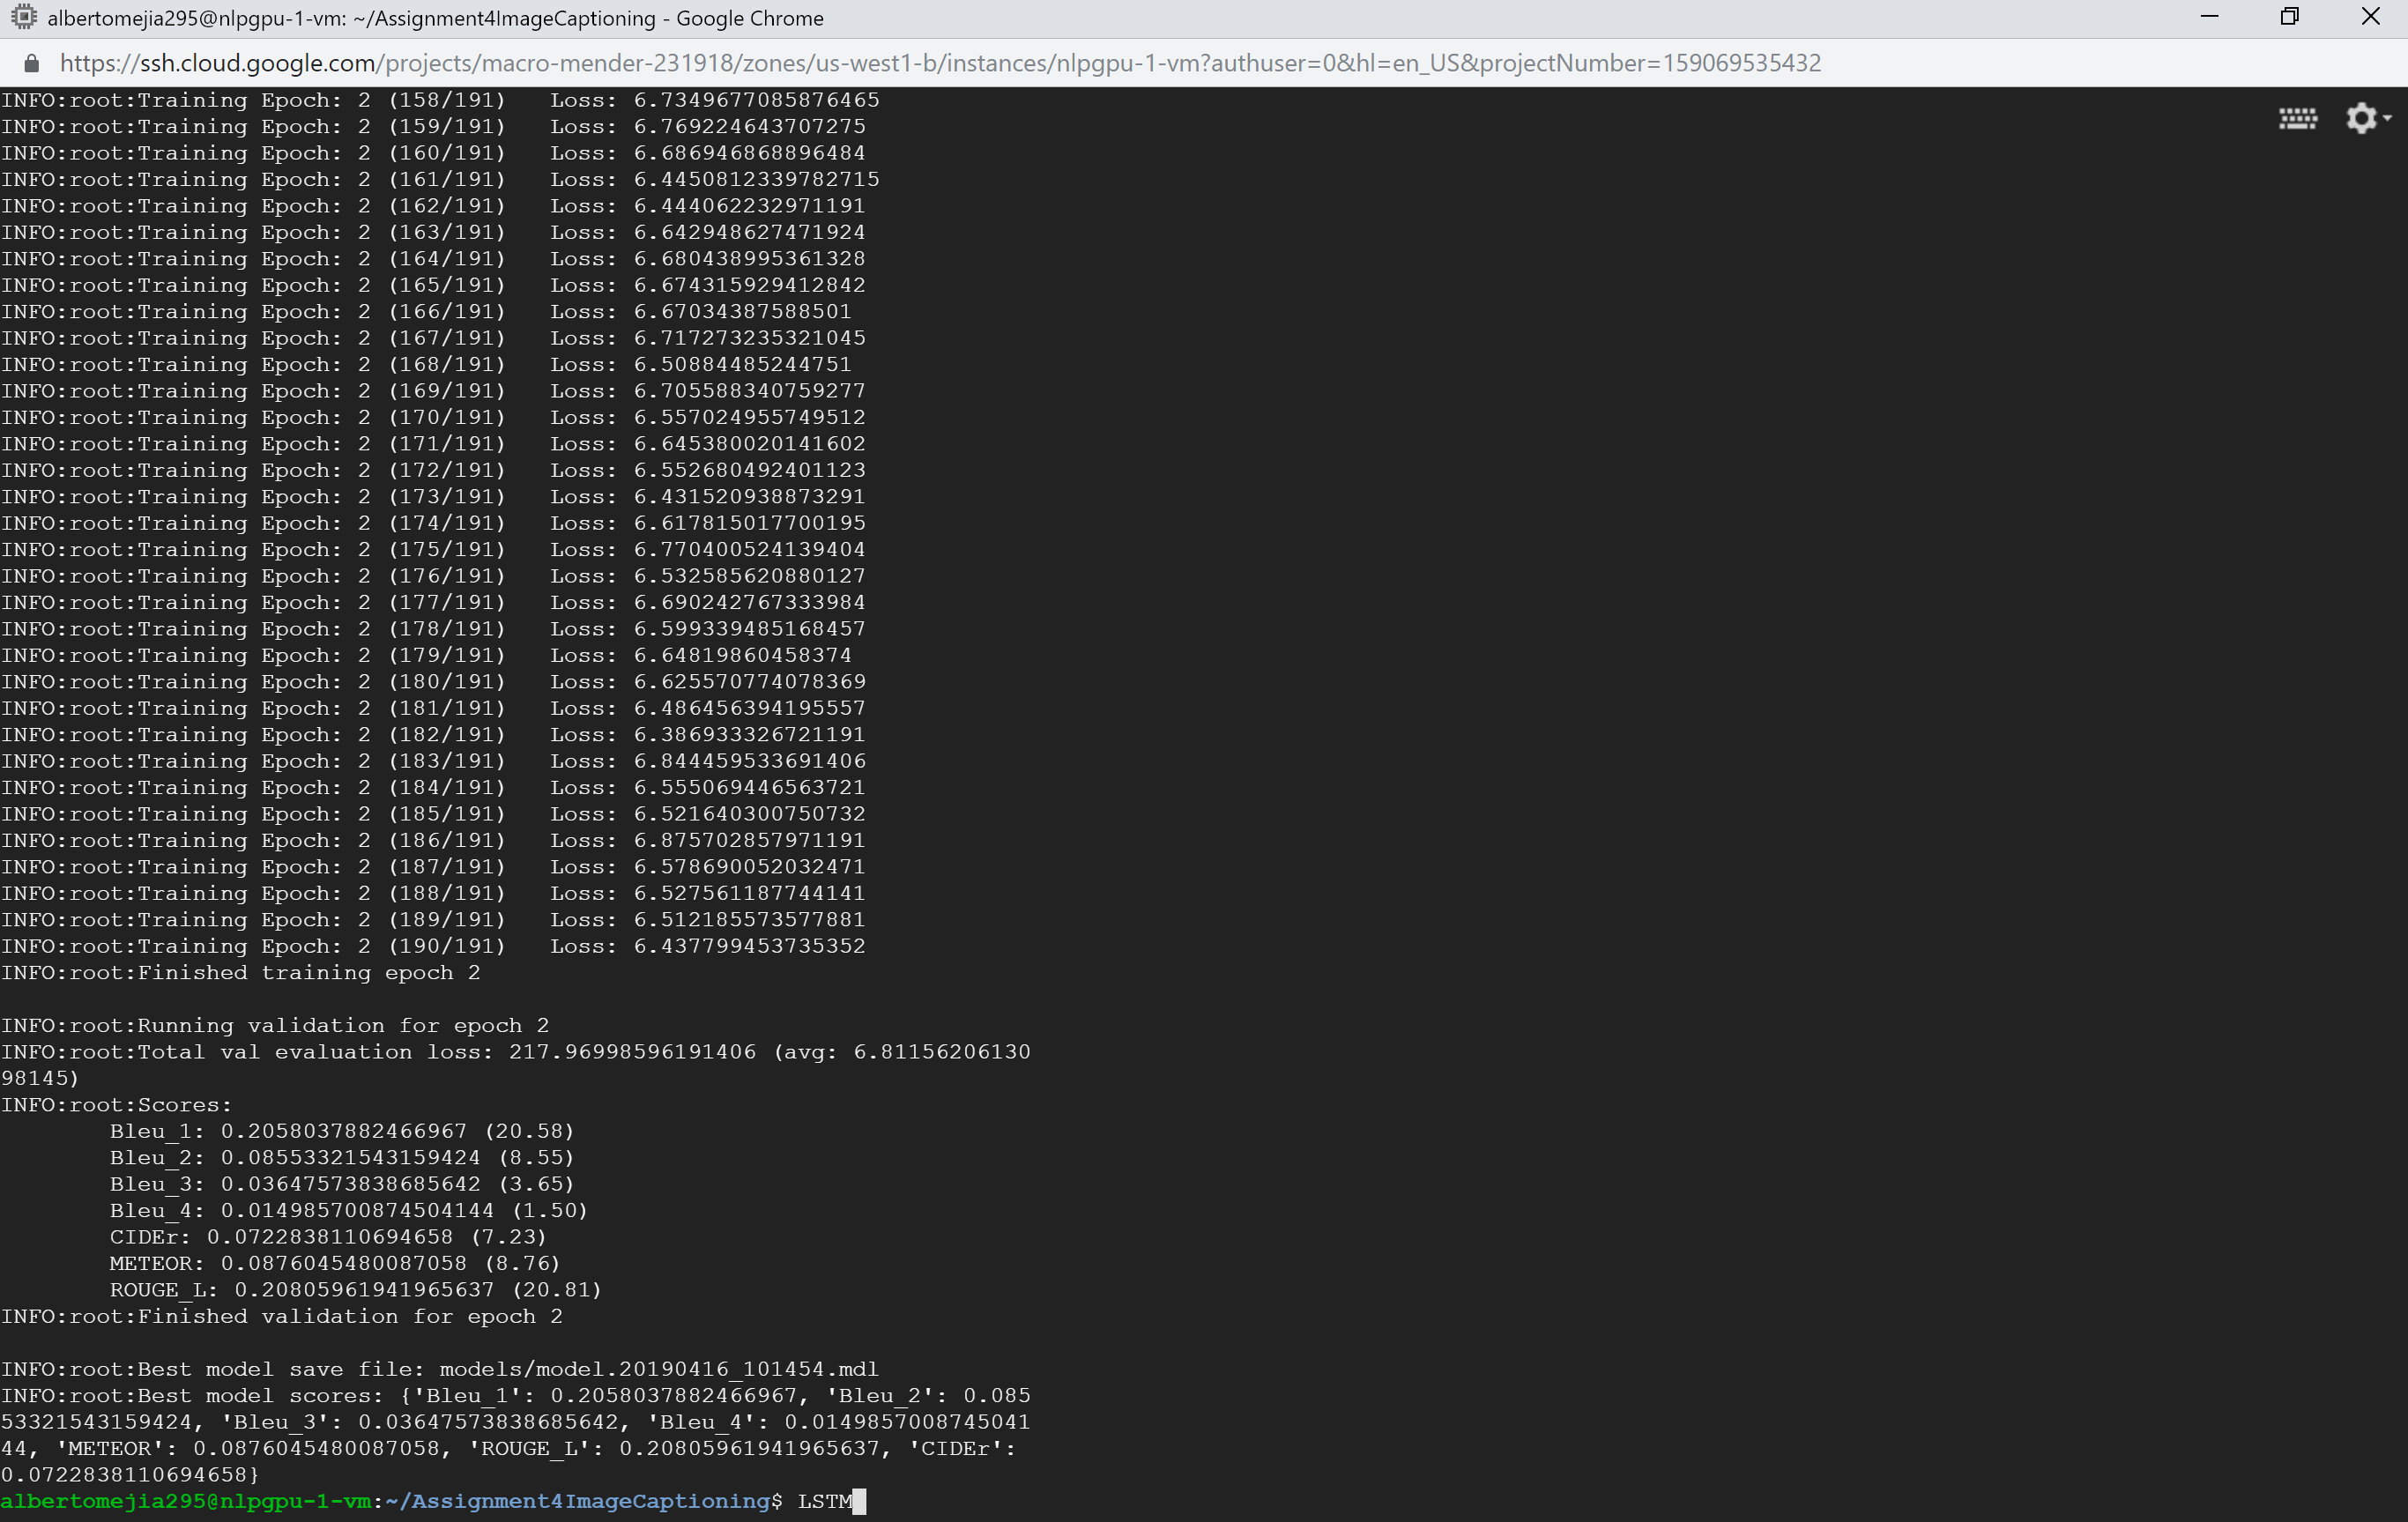

In [7]:
display(Image("./LSTM.png"))

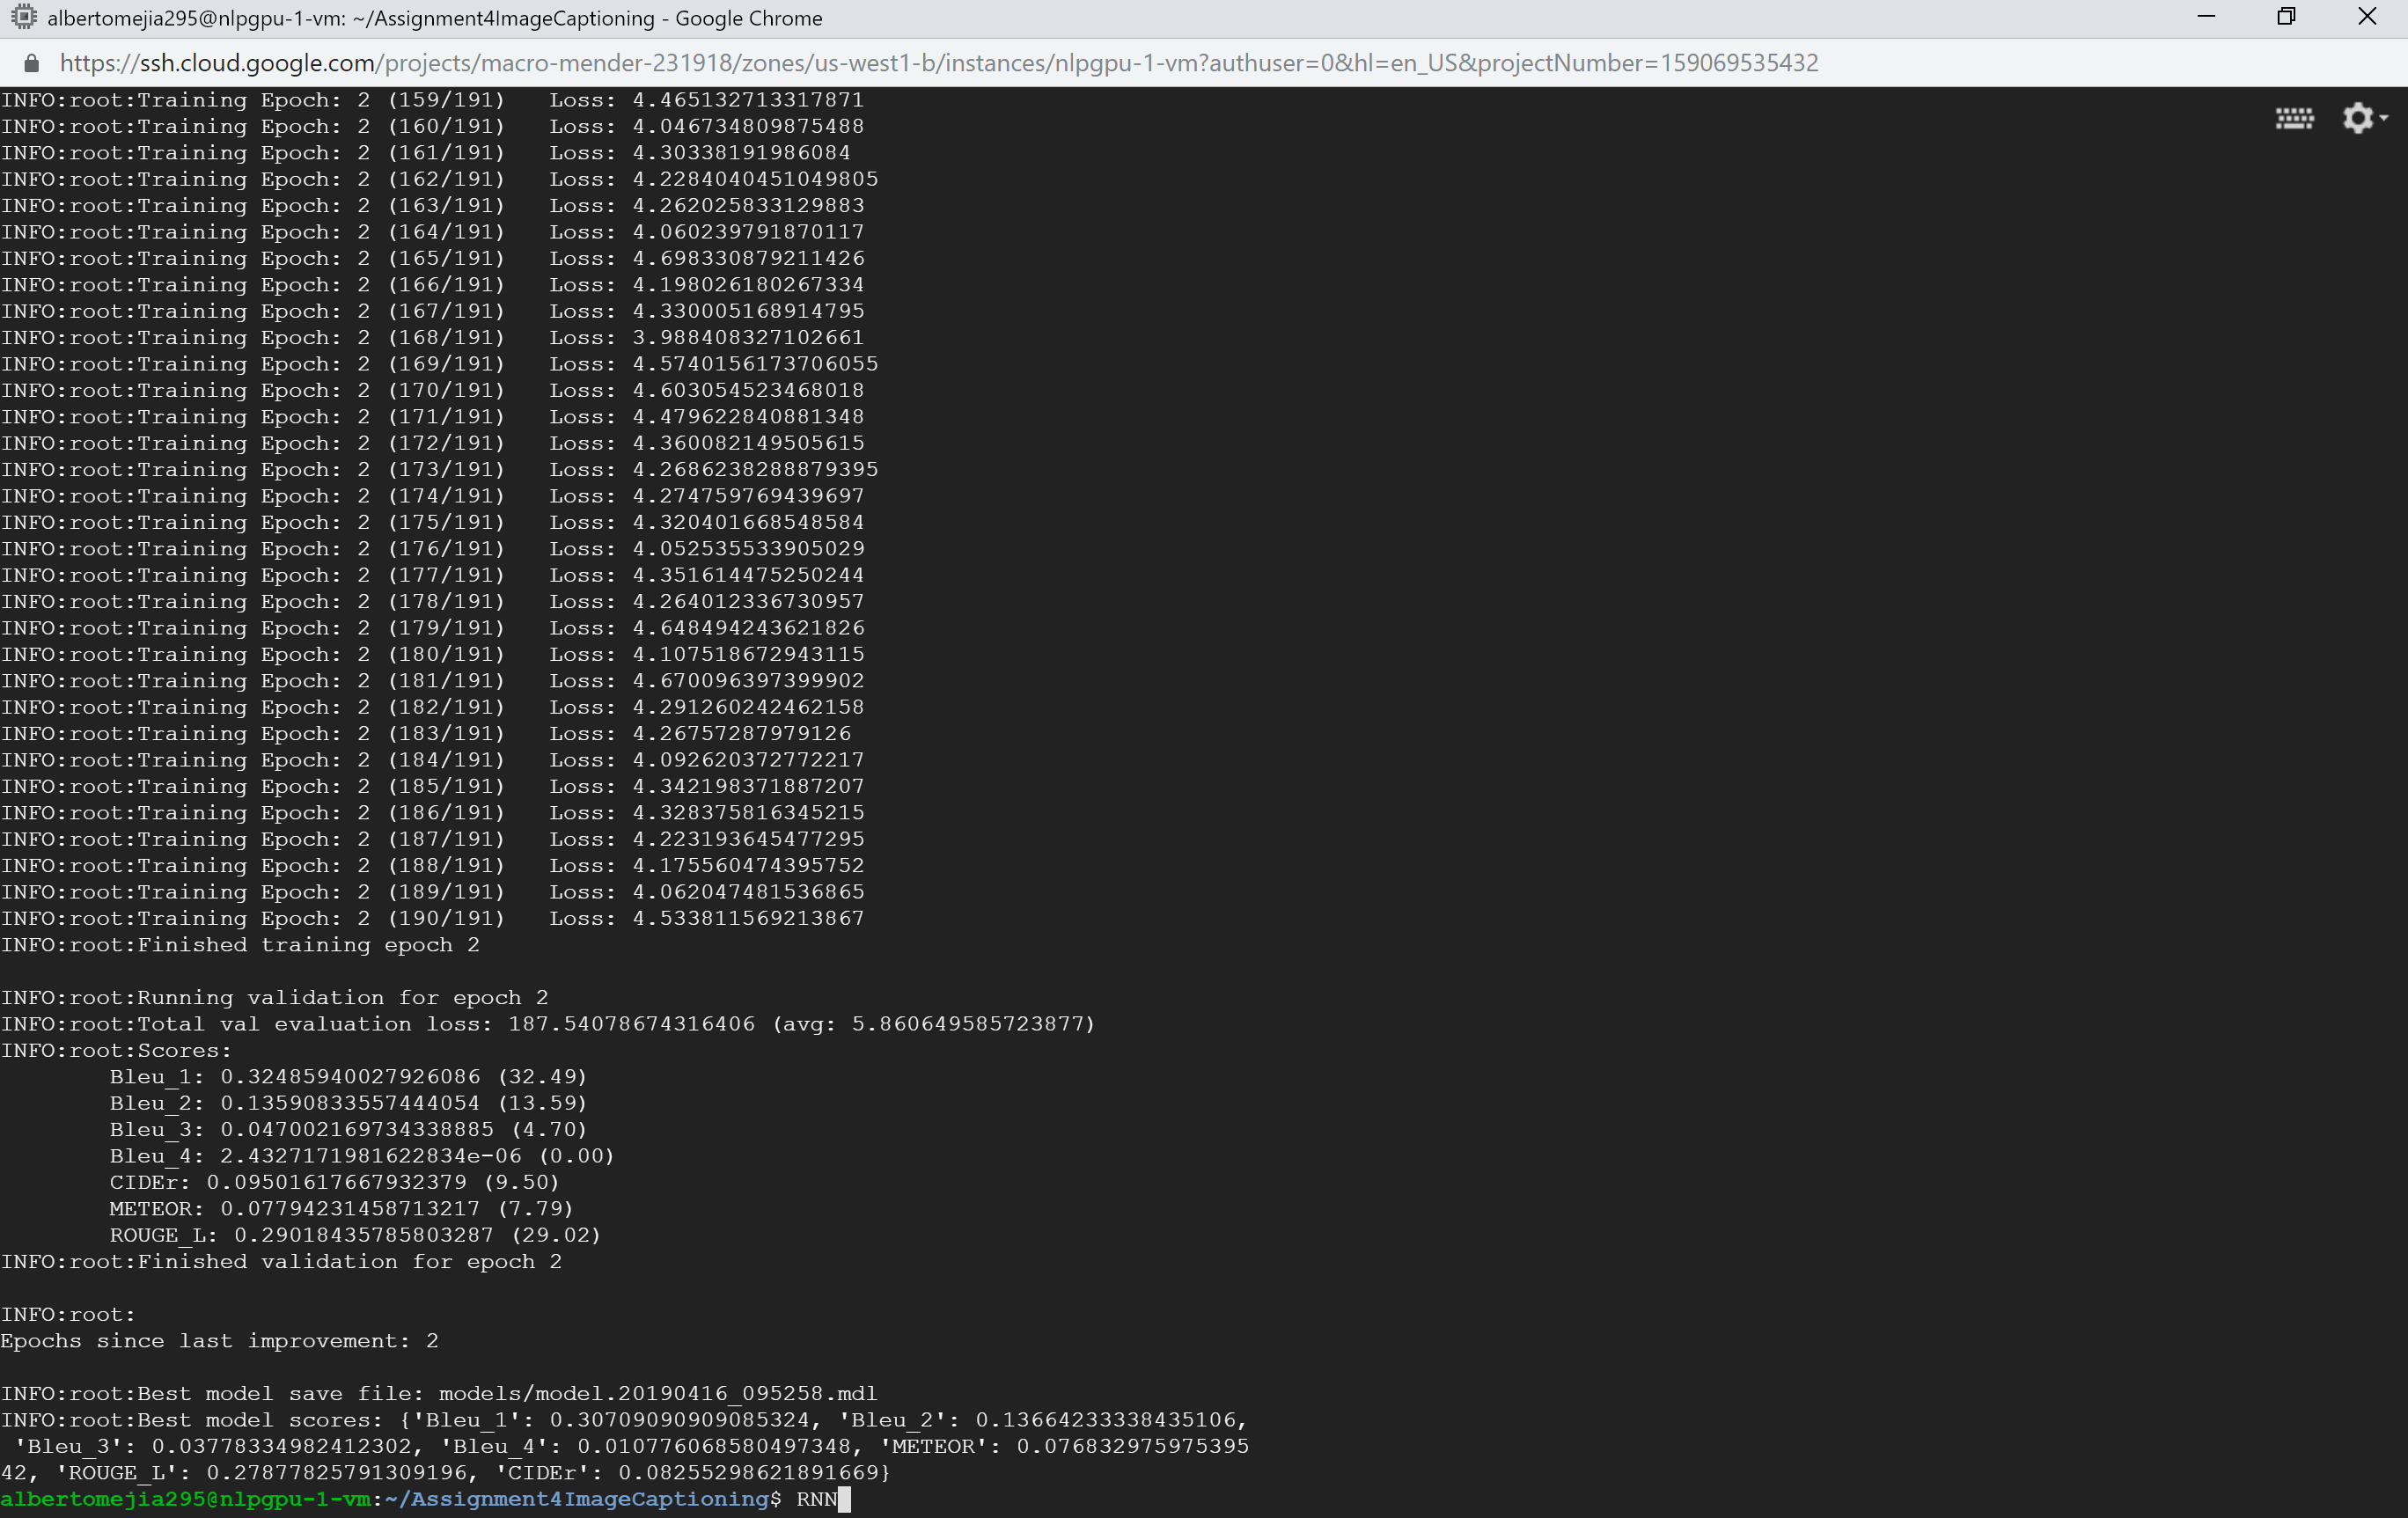

In [8]:
display(Image("./RNN.png"))

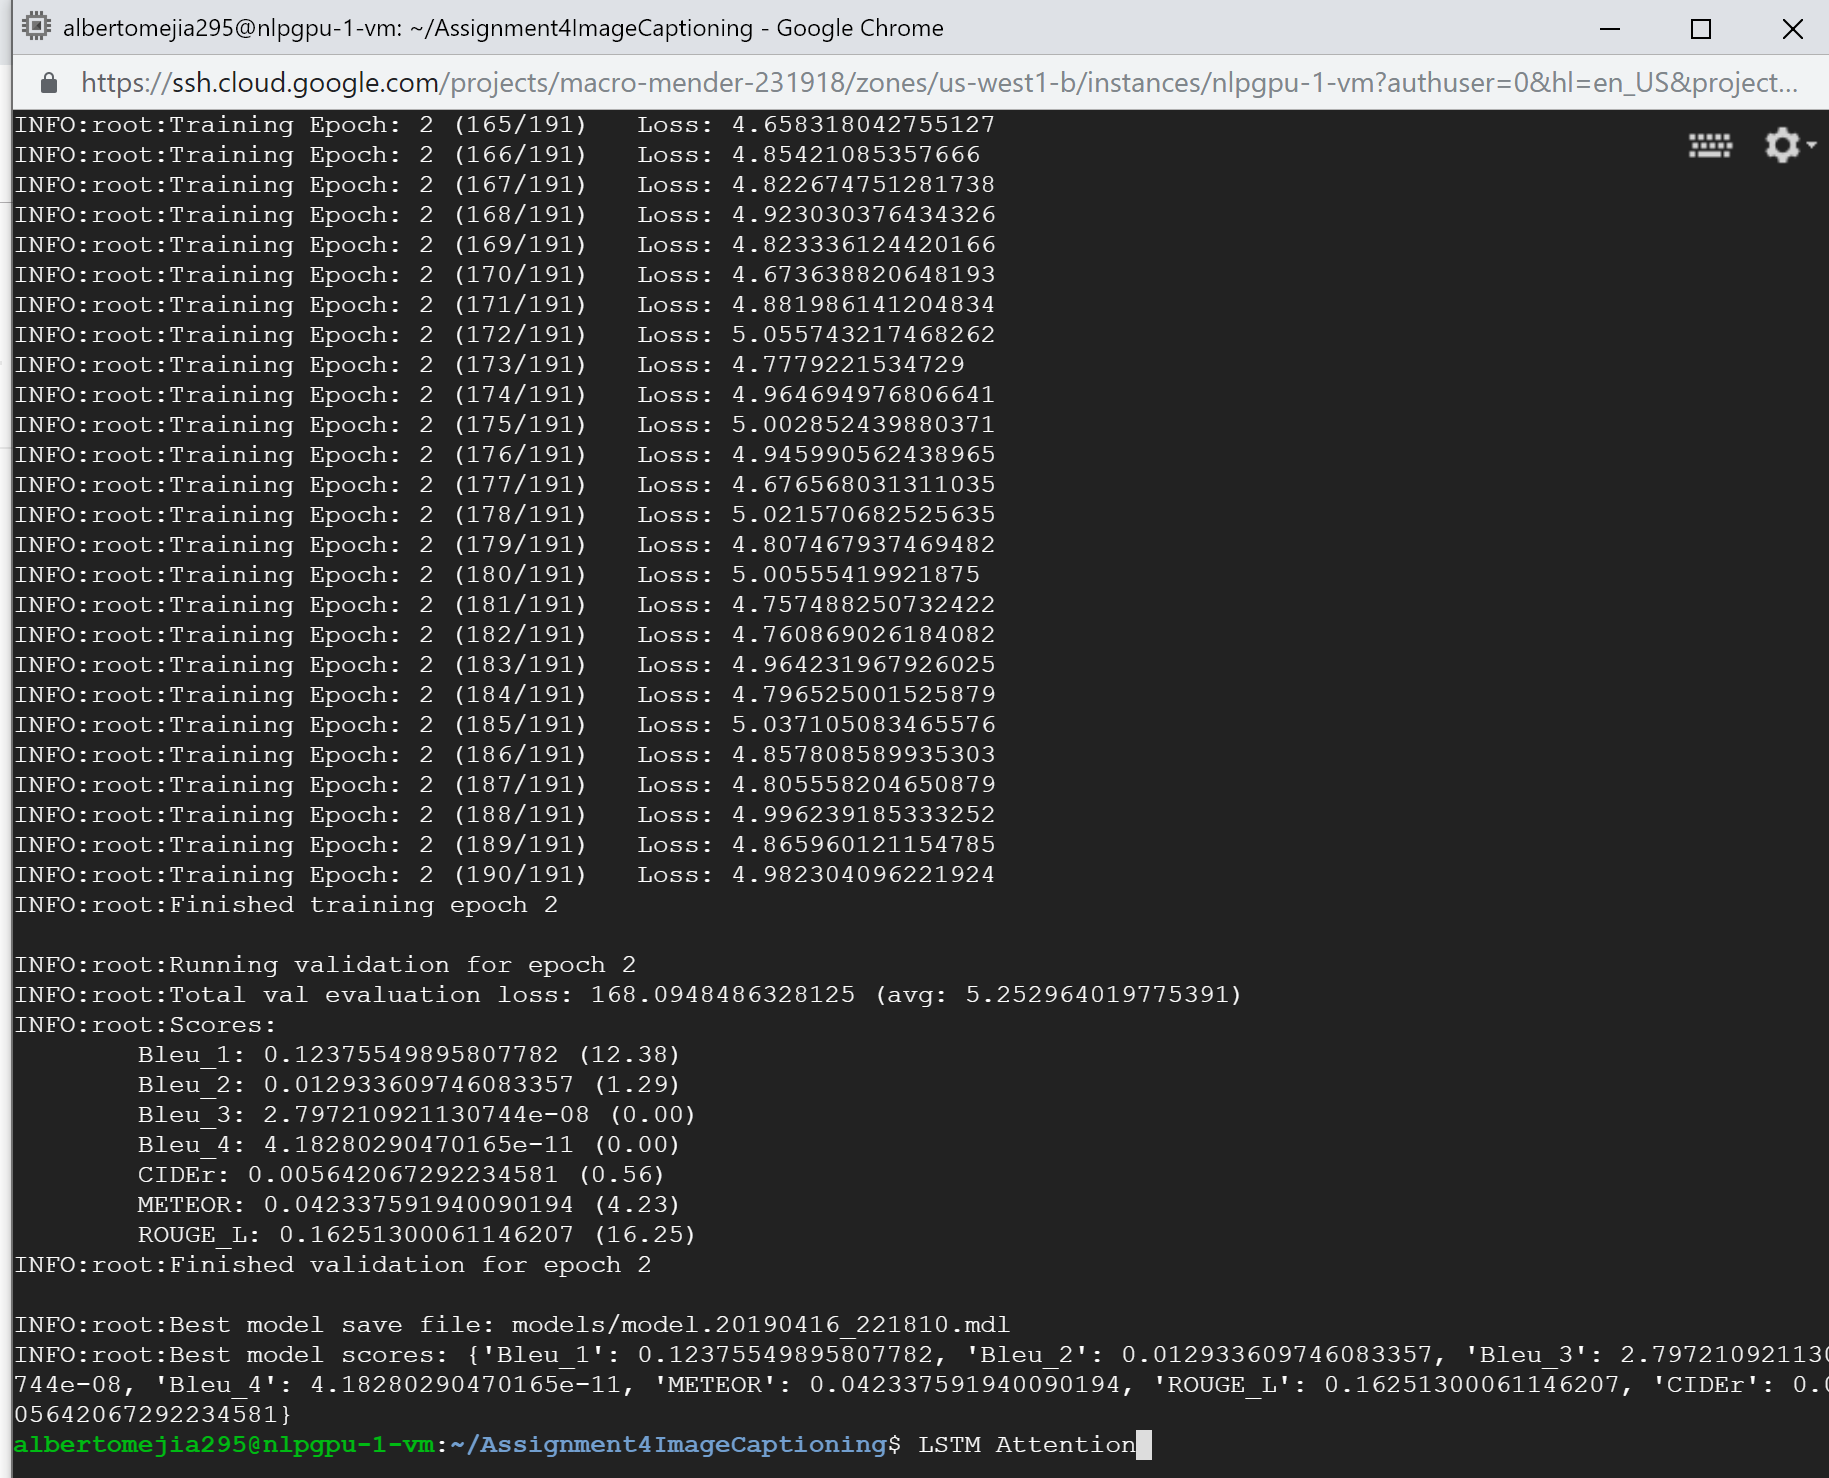

In [9]:
display(Image("./LSTM Attention.png"))

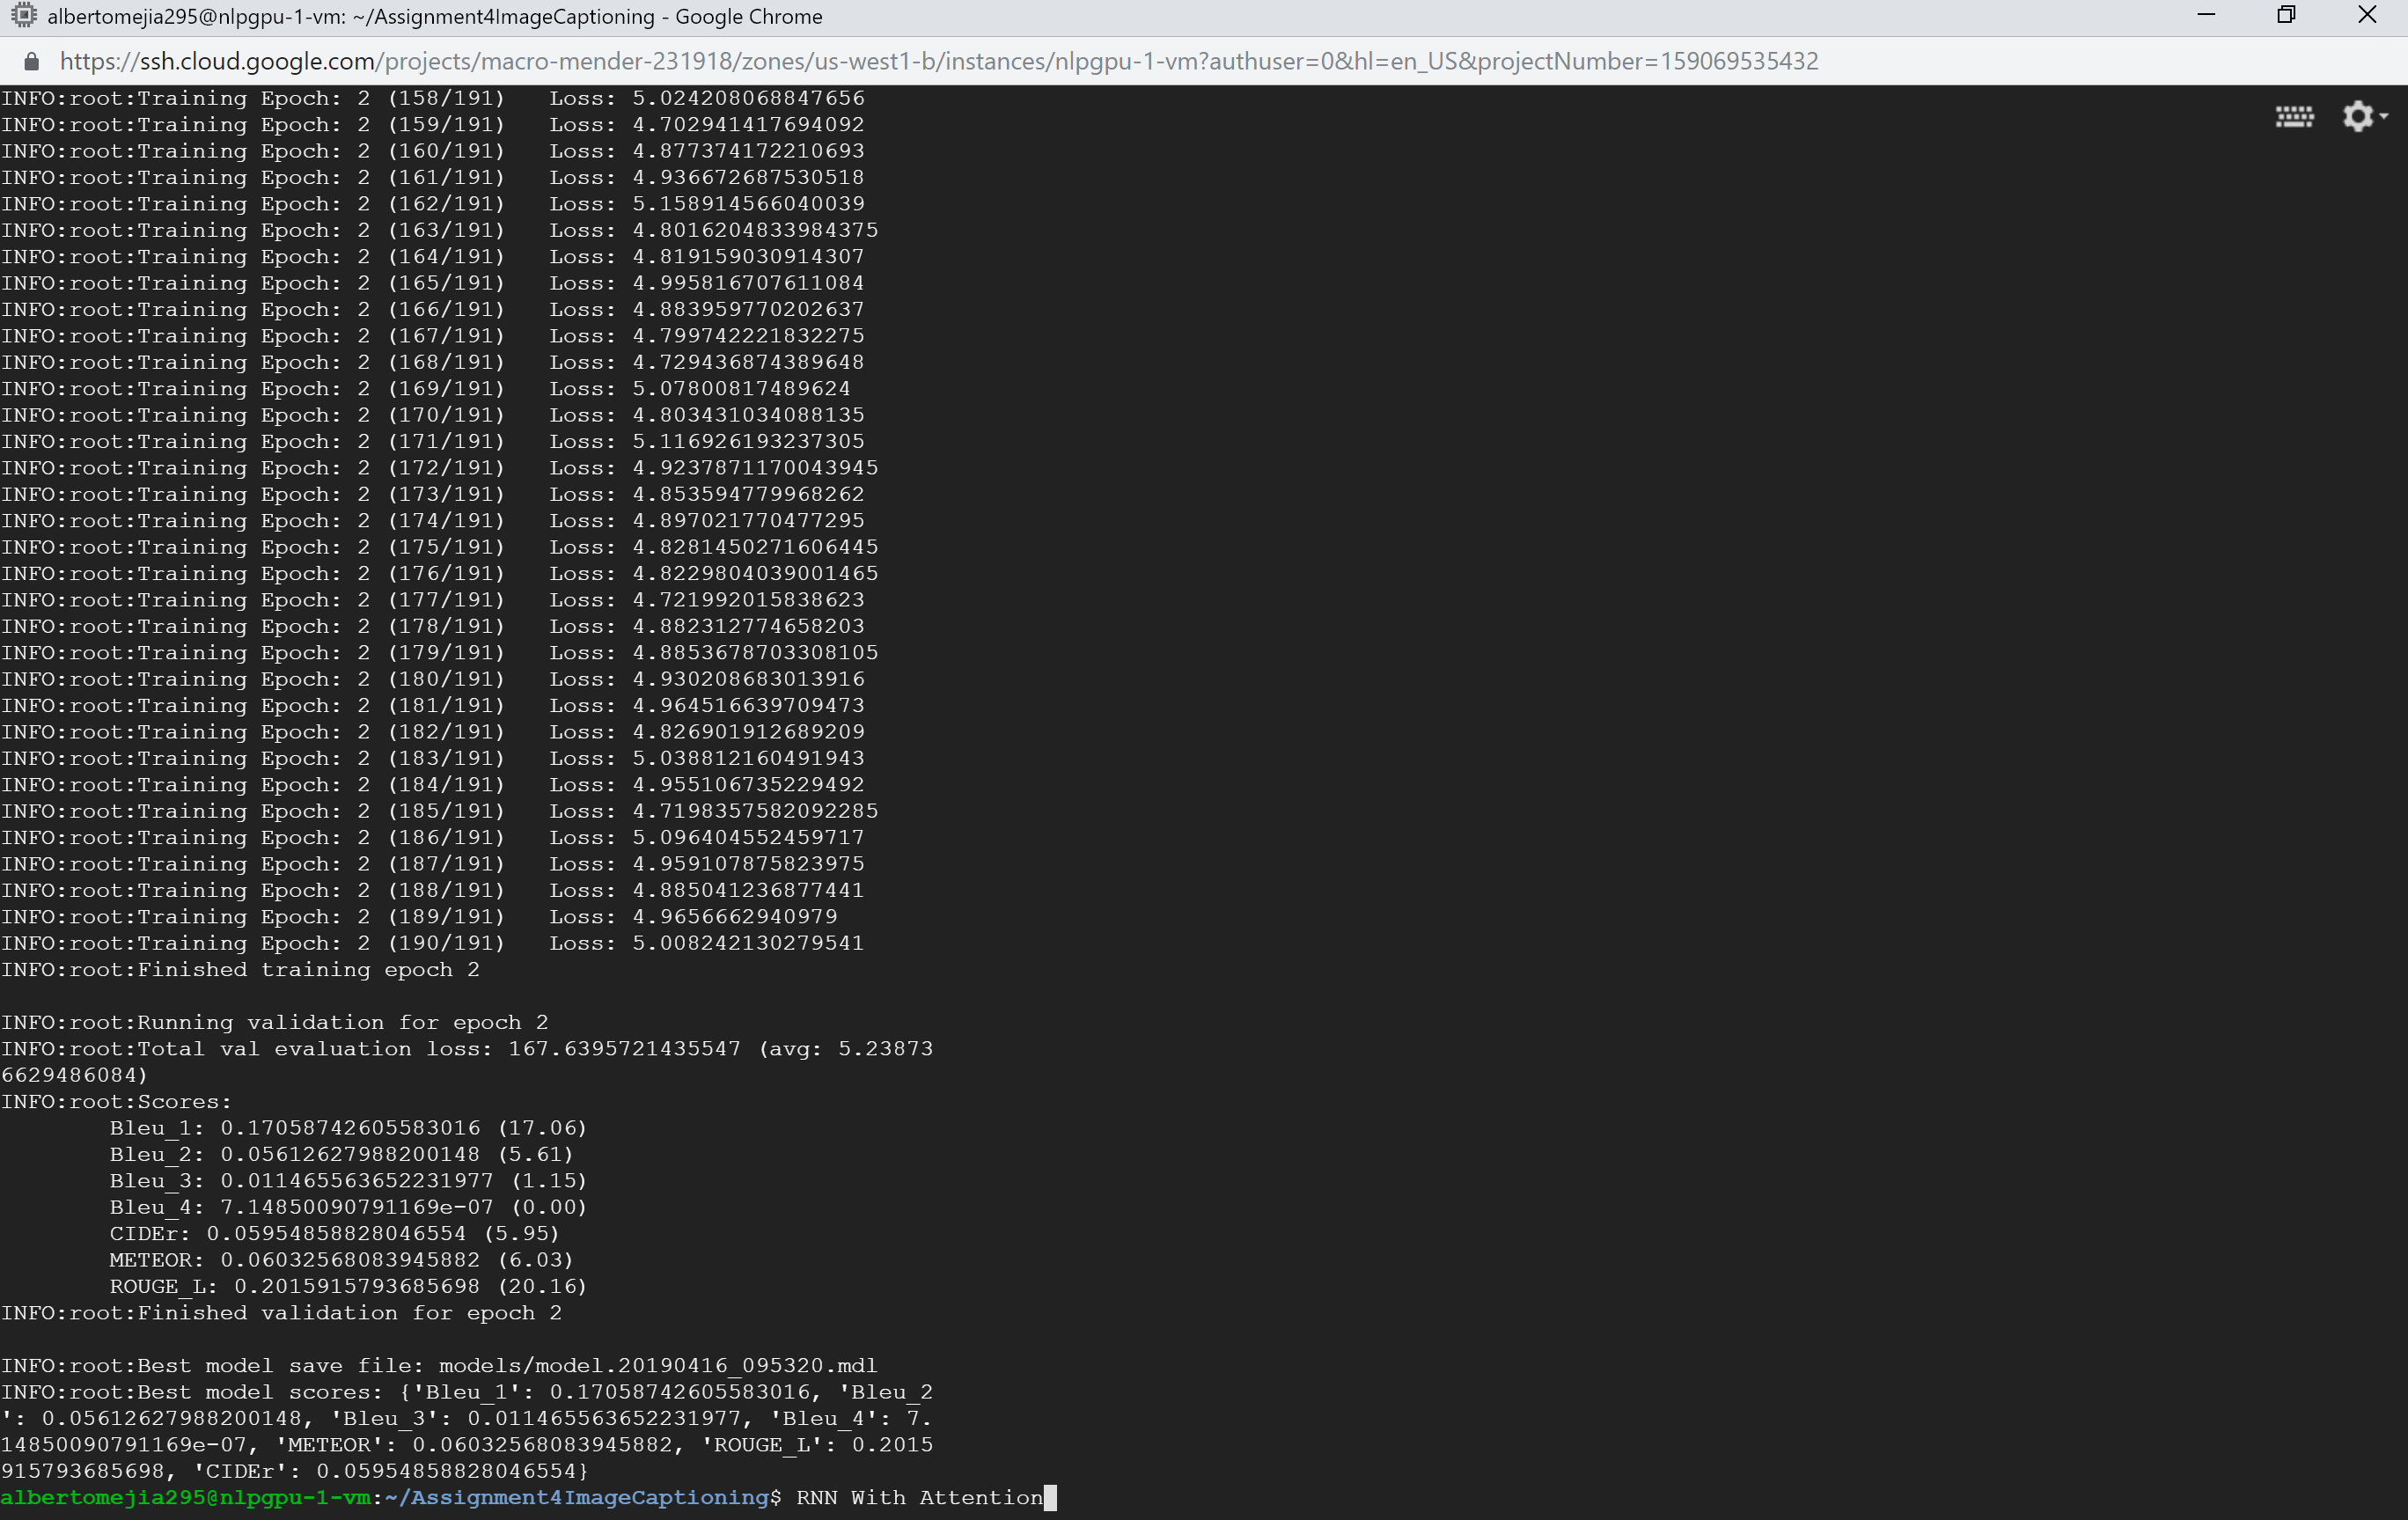

In [10]:
display(Image("./RNN Attention.png"))